[![open in colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/drscotthawley/DLAIE/blob/main/Lessons/17_Diffusion.ipynb)

# Diffusion Models

*Diffusion Models are Fun, and Based in Physics!*

--Scott H. Hawley

*Feb 4, 2004: This is a Work In Progress! 

---

Most tutorials on diffusion models go like this: "Here's the basic idea. Now here's a wall of math. Finally let's code it." 

We will try to skip as much as we can from that wall of math.  (Hint to other instructors: Nobody's gonna read your wall of math!) 

## Outline: 
1. Setting Up
2. The Idea
3. The U-Net
4. The DDPM Model
5. Train the DDPM Model
6. Have Fun with Inference

# 1. Setup

## Setup Imports

In [1]:
# we'll use pytorch lightning as an alternative to raw pytorch
!pip install -Uqq lightning wandb einops

In [2]:
import torch
from torch import nn, optim, utils
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import torchvision
import matplotlib.pyplot as plt
import torch.nn.functional as F
import lightning as L
from lightning.pytorch.loggers import WandbLogger
import wandb
import numpy as np
from einops import rearrange
from tqdm.notebook import trange, tqdm
import os

In [3]:
os.environ['CUDA_LAUNCH_BLOCKING']="1"

In [4]:
use_wandb=True
if use_wandb: 
    !pkill -f wandb
    wandb.login()

wandb: Currently logged in as: drscotthawley (strange-quarks). Use `wandb login --relogin` to force relogin


## Setup Dataset

MNIST is small and easy and you can do it on a CPU. Let's keep everything super-simple at first: black & white images.

In [5]:
train_ds = MNIST(root='./data', train=True,  download=True, transform=ToTensor())
test_ds  = MNIST(root='./data', train=False, download=True, transform=ToTensor())
val_ds = test_ds  #alias val & test
print(f"Data set lengths: train: {len(train_ds)}, test: {len(test_ds)}")

Data set lengths: train: 60000, test: 10000


Inspect it a bit..

y (target) = 5 
x.shape = (28, 28), min(x) = 0.0, max(x) = 1.0


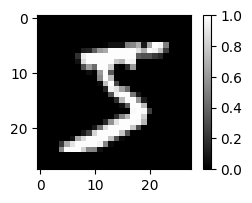

In [6]:
x, y = train_ds[0]   # pick an element
print(f"y (target) = {y} ")

def show_xs(xs, show_stats=True):
    "A little utility we'll call again & again to show one or more images"
    if type(xs) is not list: xs = list(xs)
    ncols = len(xs)
    fig, axs = plt.subplots(figsize=(3*ncols,2), ncols=ncols, squeeze=False)
    ax = axs.ravel()
    for col, x in enumerate(xs):
        if len(x.shape)>2: x = x[0] # remove any batch dimension
        if show_stats:
            if ncols > 1: print(f"col {col}: ",end="")
            print(f"x.shape = {tuple(x.shape)}, min(x) = {torch.min(x)}, max(x) = {torch.max(x)}")
        digit = ax[col].imshow(x.detach().cpu().numpy(), cmap='gray')
        fig.colorbar(digit, ax=ax[col])
    plt.show()

show_xs([x])

Define dataloaders

In [7]:
batch_size = 128
train_dl = DataLoader(train_ds, batch_size=batch_size, num_workers=4, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=batch_size, num_workers=4, shuffle=False)
val_dl = test_dl # alias val & test

## Adding Noise 

x.shape =  torch.Size([1, 28, 28])
noise_level = 9.999999747378752e-05:


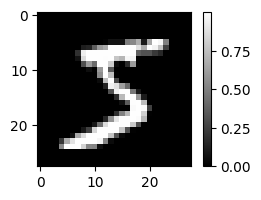

noise_level = 0.1111999973654747:


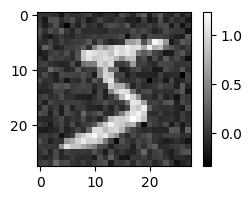

noise_level = 0.2222999930381775:


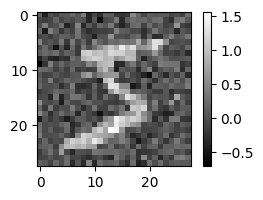

noise_level = 0.3333999812602997:


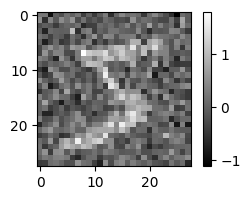

noise_level = 0.4444999694824219:


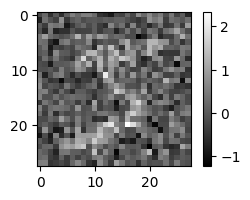

noise_level = 0.5556000471115112:


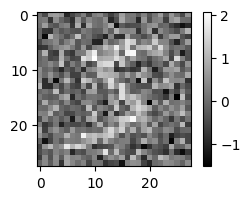

noise_level = 0.666700005531311:


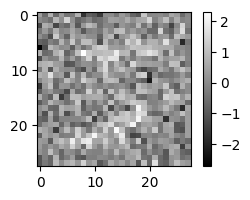

noise_level = 0.7778000235557556:


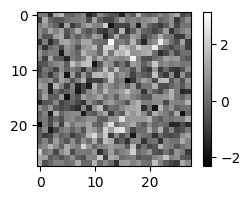

noise_level = 0.8888999819755554:


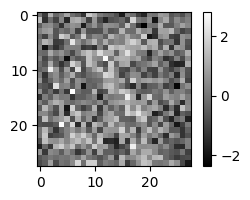

noise_level = 1.0:


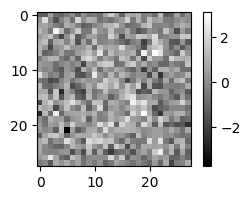

In [8]:
steps = 10
eta = 1e-4  # tiny non-zero amount that helps a bit
betas = torch.linspace(eta,1.0,steps)  # the "noise schedule": the variances of noises

def add_noise(x,noise_level): 
    noise = noise_level * torch.randn_like(x)
    return x + noise.to(x.device)

print('x.shape = ',x.shape)
for beta in betas: 
    print(f"noise_level = {noise_level}:")
    show_xs(add_noise(x,noise_level), show_stats=False)

So we will train the model to do that in reverse.


# 2. DDPM 
"Denoising Diffusion Probabilistic Model" 

Often explanations of diffusion models immediately jump into the theory of probability distributions, with REALLY BIG equations and symbols like $p_{\theta}(this|that)$ all over the place... it's easy to get lost in the math.  But the code is considerably more tractable for normal folks! We'll come back to the theory eventually, but for now let's just make it work!

While Stable Diffusion and other models do their diffusion inside a latent space provided by an [AutoEncoder](16_VAE.ipynb), for starters we'll take advantage of the small size of MNIST and just diffuse on the full image itself. 

## 2.1 U-Net
The basic architecture of a DDPM is a conditional [U-Net](11_Autoencoders_UNets_Skips_ResNets.ipynb). 

> Reminder: A U-Net is like an autoencoder but with skip connections spanning across the "hourglass" at all levels.

We're going to set it up to be  like a "denoising autoencoder".  It removes a little bit of noise from the image at every step. The noise varies from step to step via a "noise schedule", and there are different noise schedules to choose from. But the all start with no noise on one end, all "total noise" on the other. This U-Net is conditioned via the noise schedule to try to remove the specified level of noise at each step.


In [10]:

# Here's one way to make a FiLM layer
class FiLM(nn.Module):
    def __init__(self, x_dim, cond_dim):
        super().__init__()
        self.gamma_gen = nn.Linear(cond_dim, x_dim)
        self.beta_gen  = nn.Linear(cond_dim, x_dim)

    def forward(self, x, cond):
        gamma = self.gamma_gen(cond)
        beta  = self.beta_gen(cond)
        return x * gamma + beta
        

class LinearUNet(nn.Module):  # we could use convnets but for MNIST let's just get moving with Linear layers
    def __init__(self, layer_ns = [28*28, 256, 64, 3], cond_dim=1):
        super().__init__()
        self.layer_ns = layer_ns

        self.encoder_layers = nn.ModuleList([nn.Linear(layer_ns[i],layer_ns[i+1]) for i in range(len(layer_ns)-1)])
        self.decoder_layers = nn.ModuleList([nn.Linear(layer_ns[i],layer_ns[i-1]) for i in range(len(layer_ns)-1,0,-1)])
        self.act = nn.LeakyReLU() 
        self.cond_dim = cond_dim
        self.film_layers = nn.ModuleList([FiLM(layer_ns[i+1], self.cond_dim) for i in range(len(layer_ns)-2)])
        
    def forward(self,x, cond): # cond will be starting & ending noise levels
        xs = []
        if cond is not None: cond = cond.to(x.device)
        # encoder part
        nel = len(self.encoder_layers)
        for i, layer in enumerate(self.encoder_layers):
            xs.append(x)  # save for skip connections
            x = self.act( layer(x) )
            if i < nel-1 and cond is not None: x = self.film_layers[i](x,cond)

        # decoder part
        for i, layer in enumerate(self.decoder_layers):
            x = layer(x)  
            j = len(self.layer_ns)-2-i
            x = x + xs[j] # additive skip connection. real unet would concat but so it goes
            if i < len(self.film_layers): 
                x = self.act(x)
                if cond is not None: x = self.film_layers[j-1](x,cond)
            #x = torch.sigmoid(x)  # sigmoid will help keep us bounded
        return x 
            
                

unet = LinearUNet()
print(unet)

LinearUNet(
  (encoder_layers): ModuleList(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=3, bias=True)
  )
  (decoder_layers): ModuleList(
    (0): Linear(in_features=3, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=784, bias=True)
  )
  (act): LeakyReLU(negative_slope=0.01)
  (film_layers): ModuleList(
    (0): FiLM(
      (gamma_gen): Linear(in_features=1, out_features=256, bias=True)
      (beta_gen): Linear(in_features=1, out_features=256, bias=True)
    )
    (1): FiLM(
      (gamma_gen): Linear(in_features=1, out_features=64, bias=True)
      (beta_gen): Linear(in_features=1, out_features=64, bias=True)
    )
  )
)


cond.shape =  torch.Size([1])
col 0: x.shape = (28, 28), min(x) = 0.0, max(x) = 1.0
col 1: x.shape = (28, 28), min(x) = -1.0466450452804565, max(x) = 1.9796371459960938


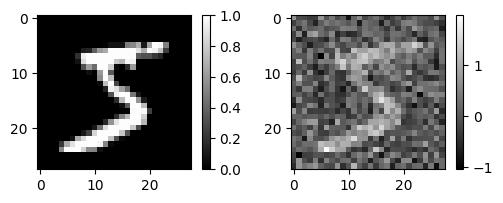

In [11]:
# test it, just to make sure we get no errors from mmult ops
x = x.view(x.size(0), -1)
cond = torch.zeros((1))
print("cond.shape = ",cond.shape)
x_hat = unet(x, cond)
x_hat = x_hat.view(x.size(0), 28, -1)
x = x.view(x.size(0), 28, -1)
show_xs([x,x_hat])

^^ That was with randomly initialized weights, so we expect some noise. Now what we'll do is set it to add a certain amount of noise. Starting with a linear noise schedule:



## 2.2 Noise Schedule Variables

I said we'd try to avoid math, but there are several quantities that we'll need to define if we want any hope of getting decent results. We're going to interpolate between a pristine image $x_0$ and a total-noise image $N(0,1)$, but we're not going to interpolate the using 'power', we're going to interpolate the 'amplitude' (which scales as the square root of the power). 

- $\beta_t$ is what you or I might call the 'power' of the noise at any time $t$.
- $\alpha_t = 1 - \beta_t$ is ihe power of  the non-noise, i.e. the contribution from the image $x_0$.
- $\overline{\alpha}_t$ is the cumulative product of all the $\alpha_t$'s from 0 up to $t$. ...TODO: try to give them a feel for that
- And then when we interpolate, since we're interpolating amplitude and not power, we need to use $\sqrt{\overline{\alpha}_t}$ and $\sqrt{1-\overline{\alpha}_t}$, to govern the relative weights of the pristine image ($x_0$) and the total noise ($N(0,1)$), respectively.  (When those get squared, then the iterpolation will work out correctly.) 

TODO: define these

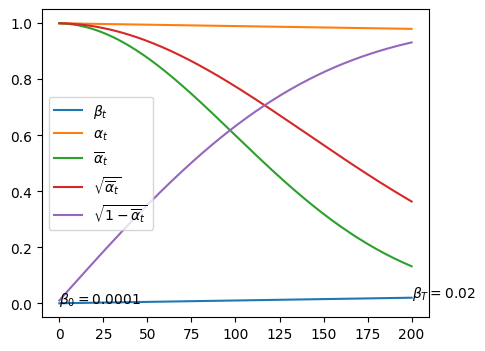

In [47]:
def plot_alphas_betas(steps=200):
    beta_0, beta_T = 0.0001, 0.02
    betas = torch.linspace(beta_0, beta_T, steps)
    ts = torch.linspace(0, steps*1.0, steps)
    alphas = 1.0 - betas
    alpha_bars = torch.cumprod(alphas,0)# .flip(0),0).flip(0)
    
    fig, ax = plt.subplots(figsize=(5,4))
    ax.plot(ts, betas, label=r'$\beta_t$')
    ax.plot(ts, alphas, label=r'$\alpha_t$')
    ax.plot(ts, alpha_bars, label=r'$\overline{\alpha}_t$')
    ax.plot(ts, torch.sqrt(alpha_bars), label=r'$\sqrt{\overline{\alpha}_t}$')
    ax.plot(ts, torch.sqrt(1-alpha_bars), label=r'$\sqrt{1-\overline{\alpha}_t}$')
    ax.text(0,  beta_0, r'$\beta_0 = $'+f'{beta_0}')
    ax.text(ts[-1],  beta_T, r'$\beta_T = $'+f'{beta_T}')
    ax.legend()
    plt.plot()

plot_alphas_betas()

## 2.3 Model Code

In [48]:
# instead of nn.Module, we use L.LightningModule
class DDPMModule(L.LightningModule):
    def __init__(self, unet, max_steps=1000, eta=1e-4):
        super().__init__()
        self.model = unet
        self.eta = eta
        self.max_steps = max_steps
        self.steps = max_steps
        beta_start,beta_end = 0.0001, 0.02
        betas = torch.linspace(beta_start, beta_end, max_steps)
        self.alphas = 1.0 - betas
        self.alpha_bars = torch.cumprod(self.alphas,0) # torch.cumprod(self.alphas.flip(0),0).flip(0)
        
    def forward(self, x, noise_level):
        return self.model(x, noise_level)

    def training_step(self, batch, batch_idx):
        x0, y = batch
        x0 = x0.view(x0.size(0), -1)  # flatten for linear layer
        
        if self.alpha_bars.device != x0.device: self.alpha_bars = self.alpha_bars.to(x0.device) 
        
        # add a bit of noise
        t_i = torch.randint(len(self.alpha_bars), (1,)).item() # random index of noise sched
        alpha_bar_t = self.alpha_bars[t_i]
        eps = torch.randn_like(x0)  # noise that what we're gonna add
        input = torch.sqrt(alpha_bar_t)* x0 + torch.sqrt(1.0 - alpha_bar_t)*eps  # here's the noise adding part

        nl_cond = torch.tensor([alpha_bar_t]).to(x0.device)                
        eps_pred = self.forward(input, nl_cond)                       # try to predict the added noise

        loss = F.mse_loss(eps_pred, eps) # target is the noise added          

        self.log('loss', loss, prog_bar=True)
        return loss

    #def validation_step(self, batch, batch_idx):
    #    loss = 0
    #    return loss 

    @torch.no_grad()
    def sample(self, demo_batch_size=16):
        model=self
        max_steps = model.max_steps
        if steps is None: steps = model.max_steps    
        x = torch.randn([demo_batch_size, 28*28]).to(model.device)   # start from random noise
        alphas = self.alphas
        term1s = 1.0/torch.sqrt(alphas)
        term2s = (1-self.alphas)/torch.sqrt(1-self.alpha_bars)
        
        for s in trange(max_steps-2,max_steps-steps-1,-1):
            alpha_bar_t = self.alpha_bars[s]
            nl_cond = torch.tensor([alpha_bar_t]).to(x.device)        
            eps_pred = model(x, nl_cond) # remove a wee bit o noise
            x = term1s[s] *(x - term2s[s] * eps_pred) 
        return x.view(x.size(0), 28, -1)


    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=1e-4)


ddpm = DDPMModule(unet)

## Training

In [49]:
if use_wandb:
    wandb.finish()
    wandb_logger = WandbLogger(log_model="all", project='ddpm_tut')
    try:
        wandb_logger.watch(model) 
    except:
        pass

In [50]:
epochs = 40
if use_wandb:
    trainer = L.Trainer(max_epochs=epochs, devices="auto", logger=wandb_logger)
    trainer.fit(model=ddpm, train_dataloaders=train_dl, val_dataloaders=val_dl )
    wandb.finish()
else:
    trainer = L.Trainer(max_epochs=epochs, devices="auto")#, logger=wandb_logger)
    trainer.fit(model=ddpm, train_dataloaders=train_dl, val_dataloaders=val_dl )
    

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/shawley/envs/dlaie/lib/python3.9/site-packages/lightning/pytorch/trainer/configuration_validator.py:72: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name  | Type       | Params
-------------------------------------
0 | model | LinearUNet | 437 K 
-------------------------------------
437 K     Trainable params
0         Non-trainable params
437 K     Total params
1.749     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=40` reached.


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▆▁▁▂▁▁▁▃▂▃▁▁▂▃▂▁▂▁▁▁▁▁▁▃▄▁▂▂▁█▁▁▁▂▁▁▁▁▁▅
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch,39
loss,9e-05
trainer/global_step,18749


## Inference

  0%|          | 0/999 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


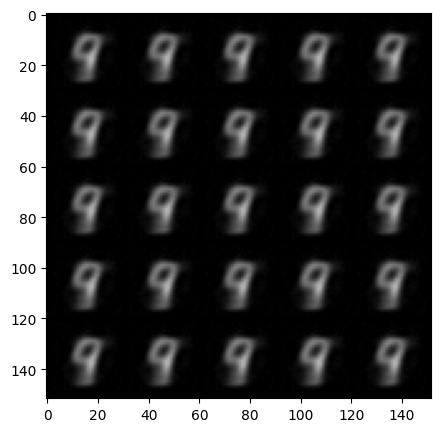

In [61]:
@torch.no_grad()
def sample(model, batch_size=16):
    max_steps = model.steps
    steps = model.max_steps
    x = torch.randn([batch_size, 28*28]).to(model.device)   # start from random noise

    alphas = model.alphas
    alpha_bars = model.alpha_bars 
    term1s = 1.0/torch.sqrt(alphas).to(model.device)
    term2s = (1-alphas)/torch.sqrt(1-alpha_bars).to(model.device)
    
    for s in trange(max_steps-2,max_steps-steps-1,-1):
        step = s
        alpha_bar_t = alpha_bars[s]
        #print("step = ",step)
        nl_cond = torch.tensor([alpha_bar_t]).to(x.device)        
        eps_pred = model(x, nl_cond) # remove a wee bit o noise
        x = term1s[s] *(x - term2s[s] * eps_pred) 
    return x.view(x.size(0), 28, -1)


def demo(model, nrows=5, ncols=5):
    batch_size = nrows*ncols
    x = sample(model, batch_size=batch_size)
    img_batch = x.unsqueeze(1) # dummy color dimension
    use_grid = True
    if use_grid:
        fig, ax = plt.subplots(figsize=(5,5))
        grid = torchvision.utils.make_grid(img_batch, nrows)
        grid = rearrange(grid, 'c h w -> h w c') 
        ax.imshow(grid.numpy())
    else:
        fig, axs = plt.subplots(figsize=(5,5),nrows=nrows, ncols=ncols, sharex=True, sharey=True)
        ax = axs.ravel()
        for i in range(batch_size):
            pane = ax[i].imshow(x[i].numpy())
        cbar_ax = fig.add_axes([0.95, 0.11, 0.05, 0.77])
        fig.colorbar(pane, cax=cbar_ax)
    plt.show()
    return

demo(ddpm)

...And there you go. you can have any number you want, as long as that number is 9. :-/

TODO: fix this. 